In [700]:
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import re,numpy as np
import spacy
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import en_core_web_sm
nlp = en_core_web_sm.load()
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from tabulate import tabulate
from colorama import Fore, Back, Style

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [926]:
print(gensim.__version__)

4.3.0


In [738]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run' ,'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [739]:
tweets_df = pd.read_csv(r'tweets/tweets.csv',engine='python')
print(tweets_df['qScore'].describe(),tweets_df['nScore'].describe())

count    10001.000000
mean         0.596829
std          0.055174
min          0.374306
25%          0.571552
50%          0.607887
75%          0.609435
max          0.820619
Name: qScore, dtype: float64 count    10001.000000
mean         0.605678
std          1.733462
min         -7.033362
25%          0.000000
50%          0.079807
75%          1.870719
max          5.259908
Name: nScore, dtype: float64


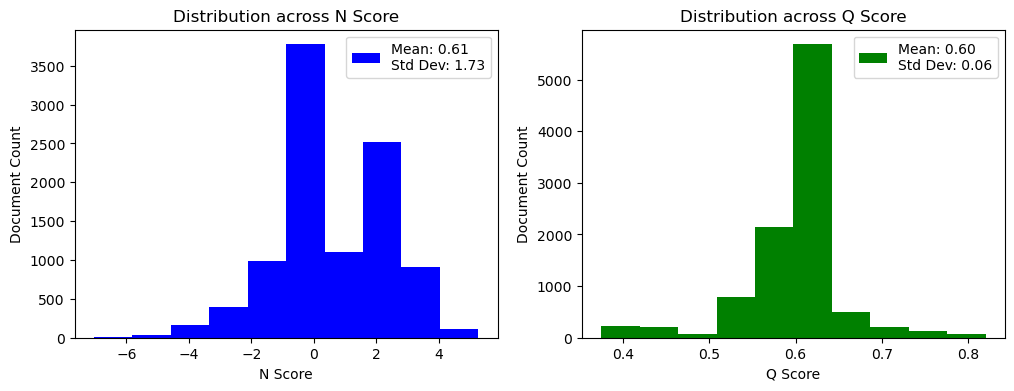

In [740]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(tweets_df['nScore'], bins=10, color='blue')
axs[0].set_title('Distribution across N Score')
axs[0].set_xlabel('N Score')
axs[0].set_ylabel('Document Count')
axs[0].legend(['Mean: {:.2f}\nStd Dev: {:.2f}'.format( np.mean(tweets_df['nScore']),np.std(tweets_df['nScore']))], loc='best')
# Plot a histogram for the q score column
axs[1].hist(tweets_df['qScore'], bins=10, color='green')
axs[1].set_title('Distribution across Q Score')
axs[1].set_xlabel('Q Score')
axs[1].set_ylabel('Document Count')
axs[1].legend(['Mean: {:.2f}\nStd Dev: {:.2f}'.format( np.mean(tweets_df['qScore']),np.std(tweets_df['qScore']))], loc='best')
# Show the plot
plt.show()

In [741]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)
# Convert to list
replacer = {
    r'#[^\s]+\W?':' ',
    r'\S*@\S*\s?':' ',
    r'\s+':' ',
    r"\'":"",
    r'\n':' ',
    r'http\S+':'',
    r'\r':'',
    r'[#()\[\]]':'',
    r'[\"\'\:\;\|\.\!\$\%\^\&\*\=\-\+\d\\\\\/\?\`\~\<\>\,\']+':''
}
tweets_df['cleantext'] = tweets_df['text'].replace(replacer,regex=True)

data_words = list(sent_to_words(tweets_df.cleantext.values.tolist()))

#using bigrams and trigrams

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#using spacy for postage such as Noun..
#define prepare data to prepare the data using nlp , bigrams and trigrams
def prepare_data(tweets, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in tweets]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    out = [[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in out]    
    return out
data_ready1 = prepare_data(data_words)

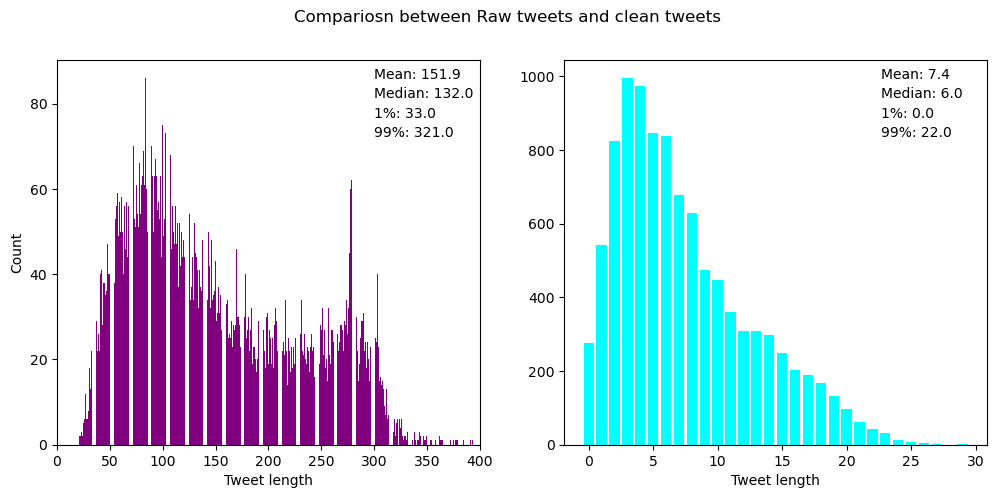

In [920]:
doc_len = [len(doc) for doc in data_ready1]
doc_counts = pd.Series(doc_len).value_counts().sort_index()
tweets_df['tweet_length'] = tweets_df['text'].apply(len)

# group by tweet length and count occurrences
tweet_counts = tweets_df.groupby('tweet_length').size().reset_index(name='count')

# plot tweet length vs count
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].bar(tweet_counts['tweet_length'],tweet_counts['count'], color='purple')
axs[0].set_xlabel('Tweet length')
axs[0].set_ylabel('Count')
axs[0].set_xlim(0, 400)

# add labels with mean, median, and percentile values
axs[0].annotate(f"Mean: {np.mean(tweets_df['tweet_length']):.1f}", xy=(0.75, 0.95), xycoords='axes fraction')
axs[0].annotate(f"Median: {np.median(tweets_df['tweet_length']):.1f}", xy=(0.75, 0.9), xycoords='axes fraction')
axs[0].annotate(f"1%: {np.percentile(tweets_df['tweet_length'], 1):.1f}", xy=(0.75, 0.85), xycoords='axes fraction')
axs[0].annotate(f"99%: {np.percentile(tweets_df['tweet_length'], 99):.1f}", xy=(0.75, 0.8), xycoords='axes fraction')
axs[1].bar(doc_counts.index, doc_counts.values, color='cyan')
axs[1].set_xlabel('Tweet length')
axs[1].annotate(f"Mean: {np.mean(doc_len):.1f}", xy=(0.75, 0.95), xycoords='axes fraction')
axs[1].annotate(f"Median: {np.median(doc_len):.1f}", xy=(0.75, 0.9), xycoords='axes fraction')
axs[1].annotate(f"1%: {np.percentile(doc_len, 1):.1f}", xy=(0.75, 0.85), xycoords='axes fraction')
axs[1].annotate(f"99%: {np.percentile(doc_len, 99):.1f}", xy=(0.75, 0.8), xycoords='axes fraction')
plt.suptitle("Compariosn between Raw tweets and clean tweets")
plt.show()

In [743]:
#basic statistics from data set
stat = tweets_df["tweet_length"]
data1 = ["Raw Data",stat.sum(),stat.mean(),stat.max(),stat.min()]
data2 = ["Cleaned Data",sum(doc_len),sum(doc_len)/len(doc_len),np.max(doc_len),np.min(doc_len)]
headers = [Fore.BLUE + "Type" + Style.RESET_ALL,
           Fore.YELLOW + "Total" + Style.RESET_ALL,
           Fore.GREEN + "Average" + Style.RESET_ALL,
           Fore.CYAN + "Max" + Style.RESET_ALL,
           Fore.MAGENTA + "Min" + Style.RESET_ALL]
print(tabulate([data1,data2], headers=headers,floatfmt=".2f",tablefmt="fancy_grid"))

╒══════════════╤════════════╤═══════════╤════════╤═══════╕
│ Type         │      Total │   Average │    Max │   Min │
╞══════════════╪════════════╪═══════════╪════════╪═══════╡
│ Raw Data     │ 1519160.00 │    151.90 │ 926.00 │ 18.00 │
├──────────────┼────────────┼───────────┼────────┼───────┤
│ Cleaned Data │   74041.00 │      7.40 │  29.00 │  0.00 │
╘══════════════╧════════════╧═══════════╧════════╧═══════╛


In [921]:
sum = 0
for i in range(10):
    sum+=doc_counts[i]
sum

7076

In [744]:
dict1 = corpora.Dictionary(data_ready1)

corp1 = [dict1.doc2bow(text) for text in data_ready1]

In [747]:
import gensim
from gensim.models import CoherenceModel

# define parameter lists
num_topics_list = [8, 10, 12]
alpha_list = [0.1, 0.5, 0.01,'symmetric']
eta_list = [0.01,0.1,0.5,'auto']
# iterate over parameter combinations
for num_topics in num_topics_list:
    for al in alpha_list:
        for et in eta_list:
        # build LDA model
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corp1,
                                                       id2word=dict1,
                                                       random_state=0,
                                                       num_topics=num_topics,
                                                       update_every=8,
                                                       chunksize=100,
                                                       passes=10,
                                                       alpha=al,
                                                       eta=et,
                                                       iterations=100,
                                                       per_word_topics=True)

            # calculate perplexity score
            perplexity_score = lda_model.log_perplexity(corp1)

            # calculate coherence score
            coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready1, corpus=corp1, coherence='c_v')
            coherence_score = coherence_model_lda.get_coherence()

            # print results
            print(f"Num Topics: {num_topics}, Alpha: {al}, Eta: {et}, Perplexity Score: {perplexity_score}, Coherence Score: {coherence_score}")

Num Topics: 8, Alpha: 0.1, Eta: 0.01, Perplexity Score: -38.621870666048395, Coherence Score: 0.34458860858607526
Num Topics: 8, Alpha: 0.1, Eta: 0.1, Perplexity Score: -9.005122634275192, Coherence Score: 0.32656379865264973
Num Topics: 8, Alpha: 0.1, Eta: 0.5, Perplexity Score: -8.8615540042106, Coherence Score: 0.3625589850853474
Num Topics: 8, Alpha: 0.1, Eta: auto, Perplexity Score: -8.802119356010843, Coherence Score: 0.34189531543137947
Num Topics: 8, Alpha: 0.5, Eta: 0.01, Perplexity Score: -38.44323692701981, Coherence Score: 0.2859843812045667
Num Topics: 8, Alpha: 0.5, Eta: 0.1, Perplexity Score: -9.100529357205671, Coherence Score: 0.29473471537714985
Num Topics: 8, Alpha: 0.5, Eta: 0.5, Perplexity Score: -8.933617190766896, Coherence Score: 0.31875812735658515
Num Topics: 8, Alpha: 0.5, Eta: auto, Perplexity Score: -8.702580022008437, Coherence Score: 0.30571514175473535
Num Topics: 8, Alpha: 0.01, Eta: 0.01, Perplexity Score: -39.67630858072242, Coherence Score: 0.3382239

In [745]:
model1 = gensim.models.ldamodel.LdaModel(corpus=corp1,
                                                       id2word=dict1,
                                                       random_state=0,
                                                       num_topics=12,
                                                       update_every=8,
                                                       chunksize=100,
                                                       passes=10,
                                                       alpha='symmetric',
                                                       eta='auto',
                                                       iterations=100,
                                                       per_word_topics=True)
model1.save('lda1.model')

vis_data1 = gensimvis.prepare(model1, corp1, dict1)
pyLDAvis.display(vis_data1)

In [749]:
coherence_model1 = CoherenceModel(model=model1,texts=data_ready1,corpus=corp1, coherence='c_v')
coherence_score1 = coherence_model1.get_coherence()
perplexity_score1 = model1.log_perplexity(corp1)
print(f"Perplexity Score: {perplexity_score1}, Coherence Score: {coherence_score1}")

Perplexity Score: -10.273859632711032, Coherence Score: 0.35595407934743917


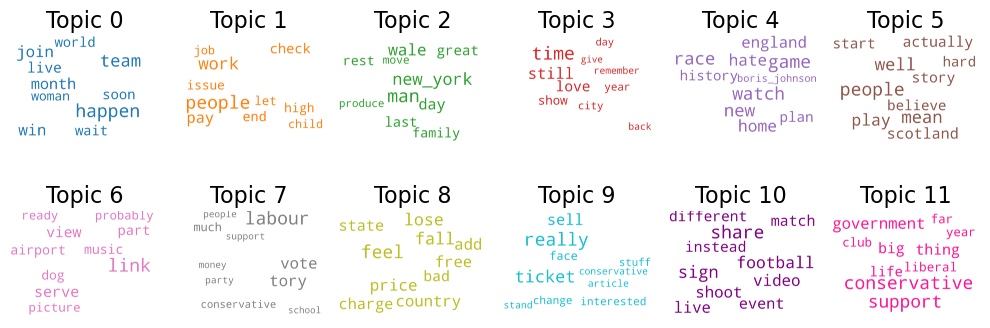

In [752]:
 # custom color library..
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#800080', '#FF1493']
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = model1.show_topics(12,formatted=False)

fig, axes = plt.subplots(2, 6, figsize=(10,4), sharex=True, sharey=True)

for i in range(len(topics)):
    ax = axes.flatten()[i]
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [756]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(model1[corp1]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 12
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7054 samples in 0.010s...
[t-SNE] Computed neighbors for 7054 samples in 0.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7054
[t-SNE] Computed conditional probabilities for sample 2000 / 7054
[t-SNE] Computed conditional probabilities for sample 3000 / 7054
[t-SNE] Computed conditional probabilities for sample 4000 / 7054
[t-SNE] Computed conditional probabilities for sample 5000 / 7054
[t-SNE] Computed conditional probabilities for sample 6000 / 7054
[t-SNE] Computed conditional probabilities for sample 7000 / 7054
[t-SNE] Computed conditional probabilities for sample 7054 / 7054
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.046829
[t-SNE] KL divergence after 1000 iterations: 0.793760


Loading BokehJS ...

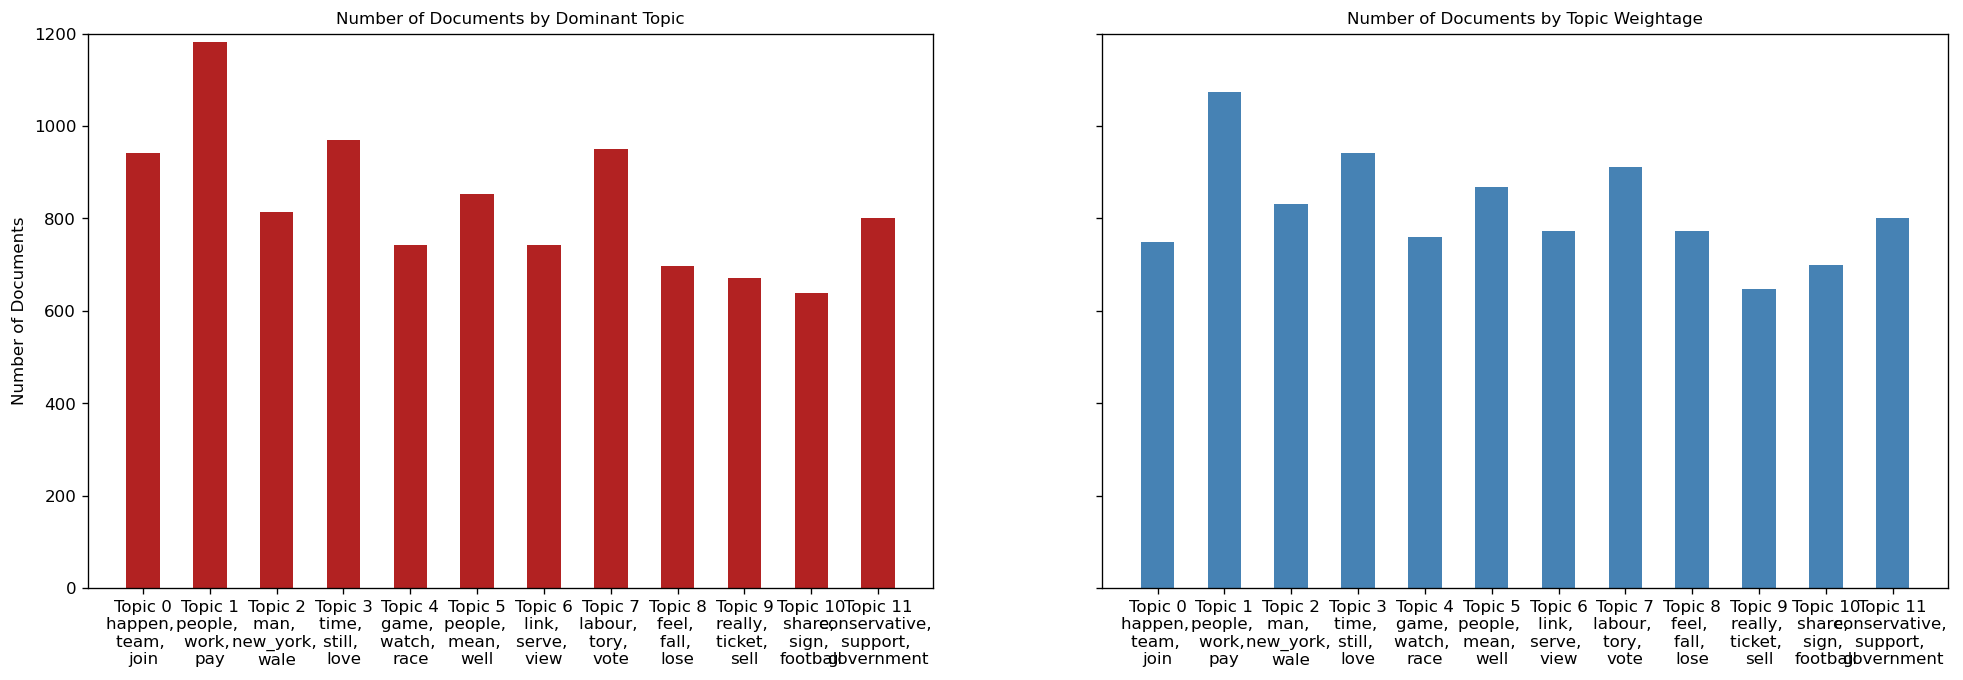

In [765]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=model1, corpus=corp1, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model1.show_topics(12,formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1200)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

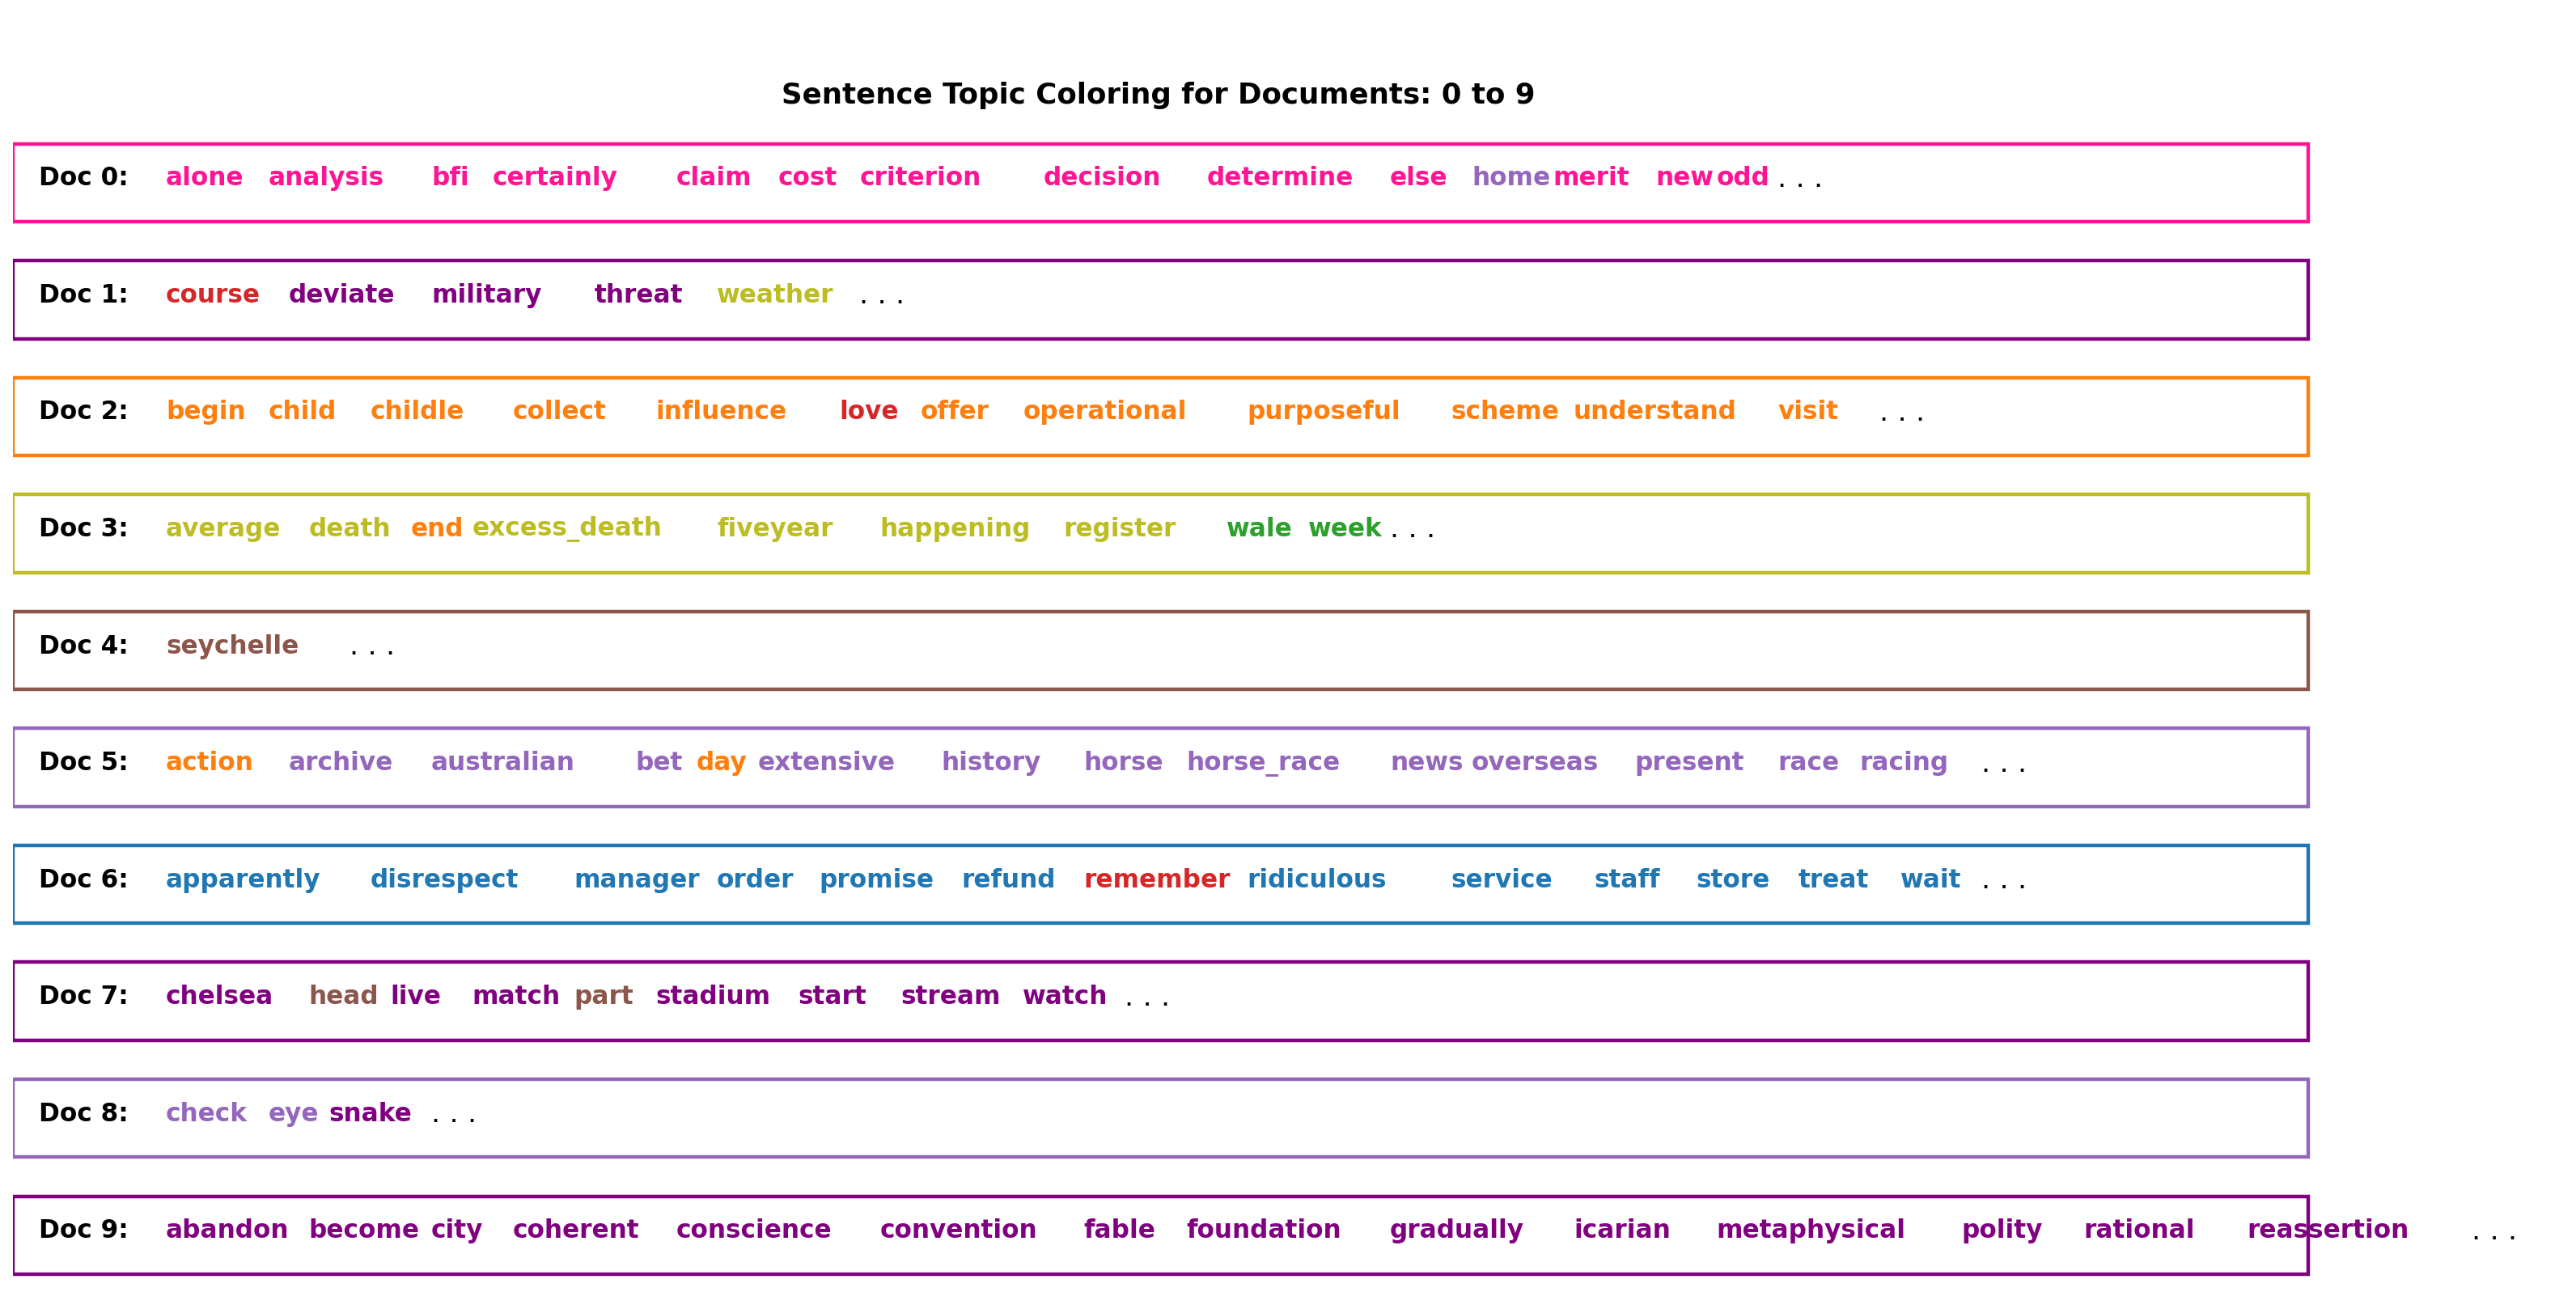

In [911]:
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=14, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.00, 0.05), 0.90, 0.80, fill=None, alpha=1, 
                                   color=colors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=14, color=colors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .008 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=16, x=0.45,y=0.9, fontweight=700)
    plt.tight_layout()
    plt.show()
sentences_chart(model1,corp1,0,11)

In [644]:
filtered_tweets = tweets_df[tweets_df['nScore']>=tweets_df['nScore'].mean()]
filtered_tweets = filtered_tweets[filtered_tweets['qScore']>=filtered_tweets['qScore'].mean()]
print(filtered_tweets.head())
data = list(sent_to_words(filtered_tweets.cleantext.values.tolist()))


bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#using spacy for postage such as Noun..
#define prepare data to prepare the data using nlp , bigrams and trigrams
def prepapre_data(tweets, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in tweets]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    out = []
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    out = [[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in out]    
    return out
data_ready2 = prepapre_data(data)

                    _id         username  \
0   1621600585291014145    realJackEason   
2   1621600585358233600       TansyWatts   
6   1621600587836956677  kathrynstimpson   
9   1621600588571049986       RuthfulThe   
12  1621600591947374594   RichMcLoughlin   

                                                 text    qScore    nScore  \
0   @pansexualflower Criterion certainly have US r...  0.613271  2.934114   
2   “As they began to understand the children’s op...  0.609156  1.772004   
6   @dominos ridiculous service from your store. R...  0.604826  2.388266   
9   de Jouvenel's Sovereignty (1957) has a fable a...  0.608509  2.969503   
12  @johnredwood The Unionists don't care about EU...  0.609500  0.655205   

                                            cleantext  tweet_length  
0    Criterion certainly have US rights to the res...           289  
2   “As they began to understand the children’s op...           192  
6    ridiculous service from your store Remembered...         

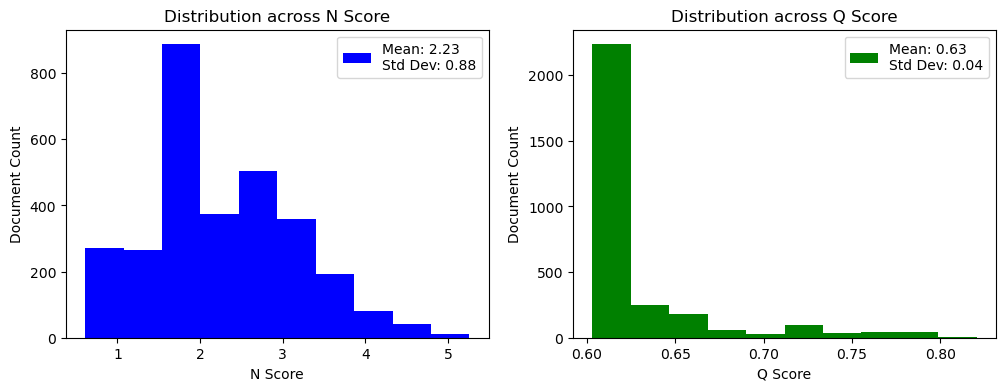

In [645]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(filtered_tweets['nScore'], bins=10, color='blue')
axs[0].set_title('Distribution across N Score')
axs[0].set_xlabel('N Score')
axs[0].set_ylabel('Document Count')
axs[0].legend(['Mean: {:.2f}\nStd Dev: {:.2f}'.format( np.mean(filtered_tweets['nScore']),np.std(filtered_tweets['nScore']))], loc='best')
# Plot a histogram for the q score column
axs[1].hist(filtered_tweets['qScore'], bins=10, color='green')
axs[1].set_title('Distribution across Q Score')
axs[1].set_xlabel('Q Score')
axs[1].set_ylabel('Document Count')
axs[1].legend(['Mean: {:.2f}\nStd Dev: {:.2f}'.format( np.mean(filtered_tweets['qScore']),np.std(filtered_tweets['qScore']))], loc='best')
# Show the plot
plt.show()

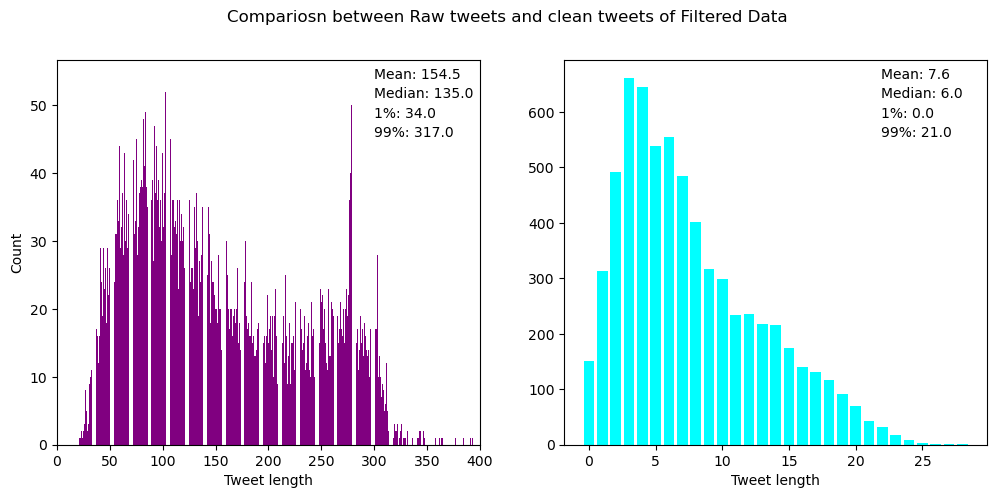

In [604]:
doc_len = [len(doc) for doc in data_ready2]
doc_counts = pd.Series(doc_len).value_counts().sort_index()
filtered_tweets['tweet_length'] = filtered_tweets['text'].apply(len)

# group by tweet length and count occurrences
tweet_counts = filtered_tweets.groupby('tweet_length').size().reset_index(name='count')

# plot tweet length vs count
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].bar(tweet_counts['tweet_length'],tweet_counts['count'], color='purple')
axs[0].set_xlabel('Tweet length')
axs[0].set_ylabel('Count')
axs[0].set_xlim(0, 400)

# add labels with mean, median, and percentile values
axs[0].annotate(f"Mean: {np.mean(filtered_tweets['tweet_length']):.1f}", xy=(0.75, 0.95), xycoords='axes fraction')
axs[0].annotate(f"Median: {np.median(filtered_tweets['tweet_length']):.1f}", xy=(0.75, 0.9), xycoords='axes fraction')
axs[0].annotate(f"1%: {np.percentile(filtered_tweets['tweet_length'], 1):.1f}", xy=(0.75, 0.85), xycoords='axes fraction')
axs[0].annotate(f"99%: {np.percentile(filtered_tweets['tweet_length'], 99):.1f}", xy=(0.75, 0.8), xycoords='axes fraction')
axs[1].bar(doc_counts.index, doc_counts.values, color='cyan')
axs[1].set_xlabel('Tweet length')
axs[1].annotate(f"Mean: {np.mean(doc_len):.1f}", xy=(0.75, 0.95), xycoords='axes fraction')
axs[1].annotate(f"Median: {np.median(doc_len):.1f}", xy=(0.75, 0.9), xycoords='axes fraction')
axs[1].annotate(f"1%: {np.percentile(doc_len, 1):.1f}", xy=(0.75, 0.85), xycoords='axes fraction')
axs[1].annotate(f"99%: {np.percentile(doc_len, 99):.1f}", xy=(0.75, 0.8), xycoords='axes fraction')
plt.suptitle("Compariosn between Raw tweets and clean tweets of Filtered Data")
plt.show()

In [674]:
dict2 = corpora.Dictionary(data_ready2)

corp2 = [dict2.doc2bow(text) for text in data_ready2]

model2 = gensim.models.ldamodel.LdaModel(corpus=corp2,
                                           id2word=dict2,
                                           random_state = 0,
                                           num_topics=8,
                                           update_every=6,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           eta = 0.06,
                                           iterations=100,
                                            per_word_topics=True)

model2.save('lda2.model')
# print all topics
# print all topics
print(model.show_topic(3))

vis_data2 = gensimvis.prepare(model2, corp2, dict2)
pyLDAvis.display(vis_data2)

[('hate', 0.013768098), ('wrong', 0.0128716305), ('sunak', 0.011647356), ('minute', 0.00923673), ('young', 0.009057849), ('hand', 0.008959917), ('head', 0.008698144), ('law', 0.008583278), ('people', 0.0081893075), ('stuff', 0.008096454)]


C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


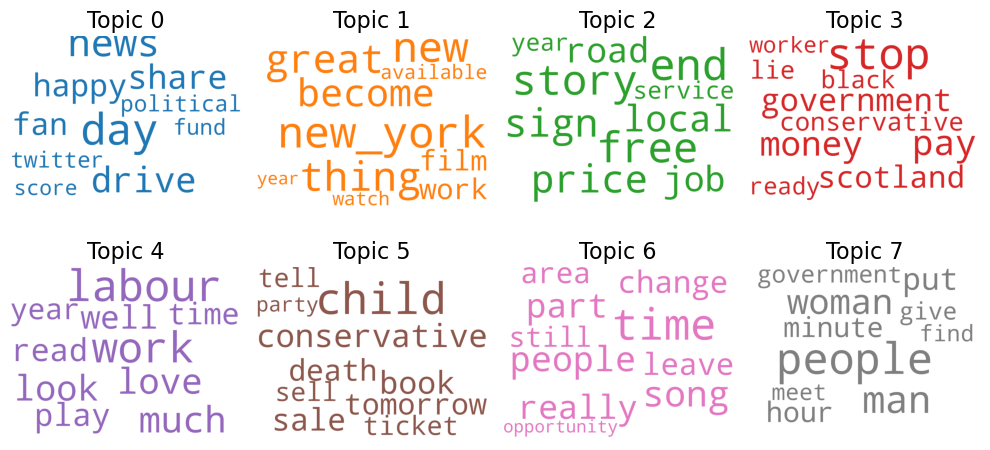

In [922]:
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#800080', '#FF1493']
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1600,
                  height=1200,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = model2.show_topics(8,formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(10,5), sharex=True, sharey=True)

for i in range(len(topics)):
    ax = axes.flatten()[i]
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [924]:
coherence_model2 = CoherenceModel(model=model2,texts=data_ready2,corpus=corp2, coherence='c_v')
coherence_score2 = coherence_model2.get_coherence()
perplexity_score2 = model2.log_perplexity(corp2)
print(f"Coherence Score: {coherence_score2}, Perplexity Score: {perplexity_score}")

Coherence Score: 0.4401107576042764, Perplexity Score: -10.273979425419348


In [790]:
grouped_tweets = pd.read_csv("tweets/groupedTweets.csv",engine='python')
grouped_tweets.head()
grouped = grouped_tweets.groupby("group")["text"].apply(lambda x: " ".join(x))
longtext_df = pd.DataFrame({"group":grouped.index,"text":grouped.values})
longtext_df['longtext'] = longtext_df['text'].replace(replacer,regex=True)
longtext_df['nScore'] = grouped_tweets.groupby("group")["nScore"].transform('mean')
longtext_df['qScore'] = grouped_tweets.groupby("group")["qScore"].transform('mean')

In [873]:
grouped_data = longtext_df.longtext.values.tolist()
grouped_data_words = list(sent_to_words(grouped_data))
bigram = gensim.models.Phrases(grouped_data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[grouped_data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
   # nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out
data_ready3 = process_words(grouped_data_words)

In [881]:
longtext_df['longtext'].str.len().max()

113597

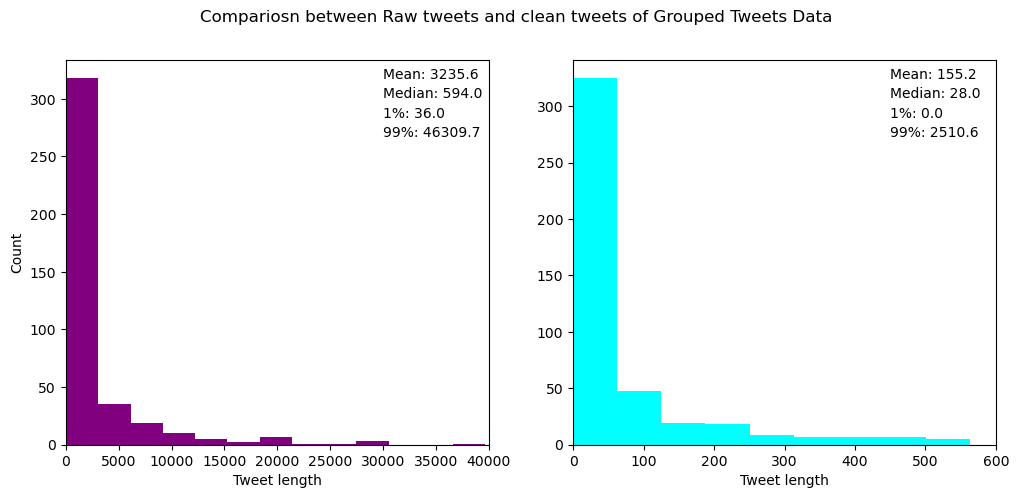

In [824]:
doc_len = [len(doc) for doc in data_ready3]
doc_counts = pd.Series(doc_len).value_counts().sort_index()
longtext_df['tweet_length'] = longtext_df['text'].apply(len)

# group by tweet length and count occurrences
tweet_counts = longtext_df.groupby('tweet_length').size().reset_index(name='count')

# plot tweet length vs count
fig, axs = plt.subplots(1,2,figsize=(12,5))
axs[0].hist(tweet_counts['tweet_length'],bins=50, color='purple')
axs[0].set_xlabel('Tweet length')
axs[0].set_ylabel('Count')
axs[0].set_xlim(0,40000)
# add labels with mean, median, and percentile values
axs[0].annotate(f"Mean: {np.mean(longtext_df['tweet_length']):.1f}", xy=(0.75, 0.95), xycoords='axes fraction')
axs[0].annotate(f"Median: {np.median(longtext_df['tweet_length']):.1f}", xy=(0.75, 0.9), xycoords='axes fraction')
axs[0].annotate(f"1%: {np.percentile(longtext_df['tweet_length'], 1):.1f}", xy=(0.75, 0.85), xycoords='axes fraction')
axs[0].annotate(f"99%: {np.percentile(longtext_df['tweet_length'], 99):.1f}", xy=(0.75, 0.8), xycoords='axes fraction')
axs[1].hist(doc_len,bins=100, color='cyan')
axs[1].set_xlabel('Tweet length')
axs[1].annotate(f"Mean: {np.mean(doc_len):.1f}", xy=(0.75, 0.95), xycoords='axes fraction')
axs[1].annotate(f"Median: {np.median(doc_len):.1f}", xy=(0.75, 0.9), xycoords='axes fraction')
axs[1].annotate(f"1%: {np.percentile(doc_len, 1):.1f}", xy=(0.75, 0.85), xycoords='axes fraction')
axs[1].annotate(f"99%: {np.percentile(doc_len, 99):.1f}", xy=(0.75, 0.8), xycoords='axes fraction')
axs[1].set_xlim(0,600)
plt.suptitle("Compariosn between Raw tweets and clean tweets of Grouped Tweets Data")
plt.show()

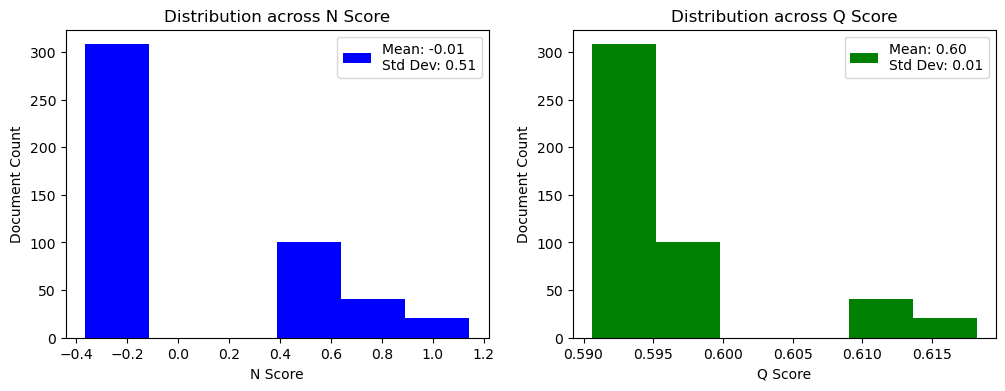

In [822]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].hist(longtext_df['nScore'], bins=6, color='blue')
axs[0].set_title('Distribution across N Score')
axs[0].set_xlabel('N Score')
axs[0].set_ylabel('Document Count')
axs[0].legend(['Mean: {:.2f}\nStd Dev: {:.2f}'.format( np.mean(longtext_df['nScore']),np.std(longtext_df['nScore']))], loc='best')
# Plot a histogram for the q score column
axs[1].hist(longtext_df['qScore'], bins=6, color='green')
axs[1].set_title('Distribution across Q Score')
axs[1].set_xlabel('Q Score')
axs[1].set_ylabel('Document Count')
axs[1].legend(['Mean: {:.2f}\nStd Dev: {:.2f}'.format( np.mean(longtext_df['qScore']),np.std(longtext_df['qScore']))], loc='best')
# Show the plot
plt.show()

In [825]:
stat = longtext_df["tweet_length"]
data1 = ["Raw Data",stat.sum(),stat.mean(),stat.max(),stat.min()]
data2 = ["Cleaned Data",sum(doc_len),sum(doc_len)/len(doc_len),np.max(doc_len),np.min(doc_len)]
headers = [Fore.BLUE + "Type" + Style.RESET_ALL,
           Fore.YELLOW + "Total" + Style.RESET_ALL,
           Fore.GREEN + "Average" + Style.RESET_ALL,
           Fore.CYAN + "Max" + Style.RESET_ALL,
           Fore.MAGENTA + "Min" + Style.RESET_ALL]
print(tabulate([data1,data2], headers=headers,floatfmt=".2f",tablefmt="fancy_grid"))

╒══════════════╤════════════╤═══════════╤═══════════╤═══════╕
│ Type         │      Total │   Average │       Max │   Min │
╞══════════════╪════════════╪═══════════╪═══════════╪═══════╡
│ Raw Data     │ 1523951.00 │   3235.56 │ 152602.00 │ 31.00 │
├──────────────┼────────────┼───────────┼───────────┼───────┤
│ Cleaned Data │   73083.00 │    155.17 │   6260.00 │  0.00 │
╘══════════════╧════════════╧═══════════╧═══════════╧═══════╛


In [843]:
dict3 = corpora.Dictionary(data_ready3)

# Create Corpus: Term Document Frequency
corpus3 = [dict3.doc2bow(text) for text in data_ready3]

# Build LDA model
model3 = gensim.models.ldamodel.LdaModel(corpus=corpus3,
                                           id2word=dict3,
                                           random_state = 0,
                                           num_topics=5,
                                           update_every=3,
                                           chunksize=100,
                                           passes=10,
                                           alpha='symmetric',
                                           eta = 0.5,
                                           iterations=100,
                                           per_word_topics=True)

# pprint(model.print_topics())
# save model to disk (no need to use pickle module)
model3.save('lda3.model')
vis_data3 = gensimvis.prepare(model3, corpus3,dict3)
pyLDAvis.display(vis_data3)

In [845]:
coherence_model3 = CoherenceModel(model=model3,texts=data_ready3,corpus=corpus3, coherence='c_v')
coherence_score3 = coherence_model3.get_coherence()
perplexity_score3 = model3.log_perplexity(corpus3)
print(f"Perplexity Score: {perplexity_score3}, Coherence Score: {coherence_score3}")

Perplexity Score: -8.406083958730193, Coherence Score: 0.32456844088626857


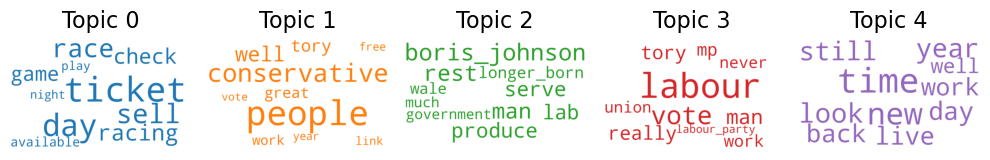

In [842]:
colors = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#800080', '#FF1493']
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=1600,
                  height=1000,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: colors[i],
                  prefer_horizontal=1.0)

topics = model3.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(10,4), sharex=True, sharey=True)

for i in range(len(topics)):
    ax = axes.flatten()[i]
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [846]:
topic_weights = []
for i, row_list in enumerate(model3[corpus3]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 459 samples in 0.003s...
[t-SNE] Computed neighbors for 459 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 459 / 459
[t-SNE] Mean sigma: 0.004584
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.130474
[t-SNE] KL divergence after 1000 iterations: 0.112034


Loading BokehJS ...

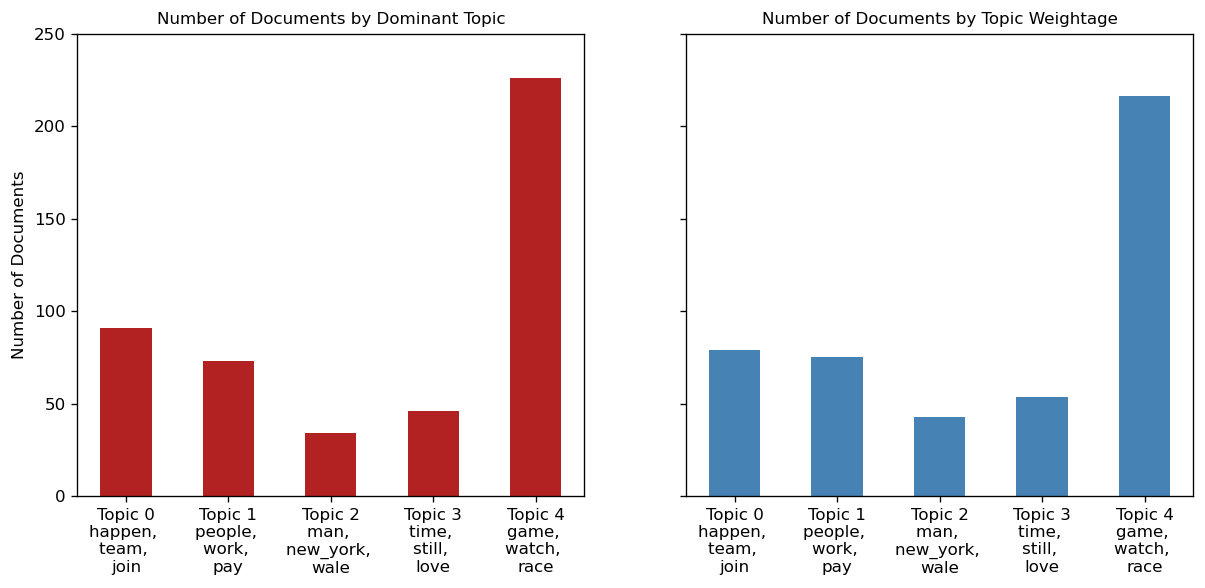

In [864]:
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=model3, corpus=corpus3, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in model1.show_topics(12,formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 250)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

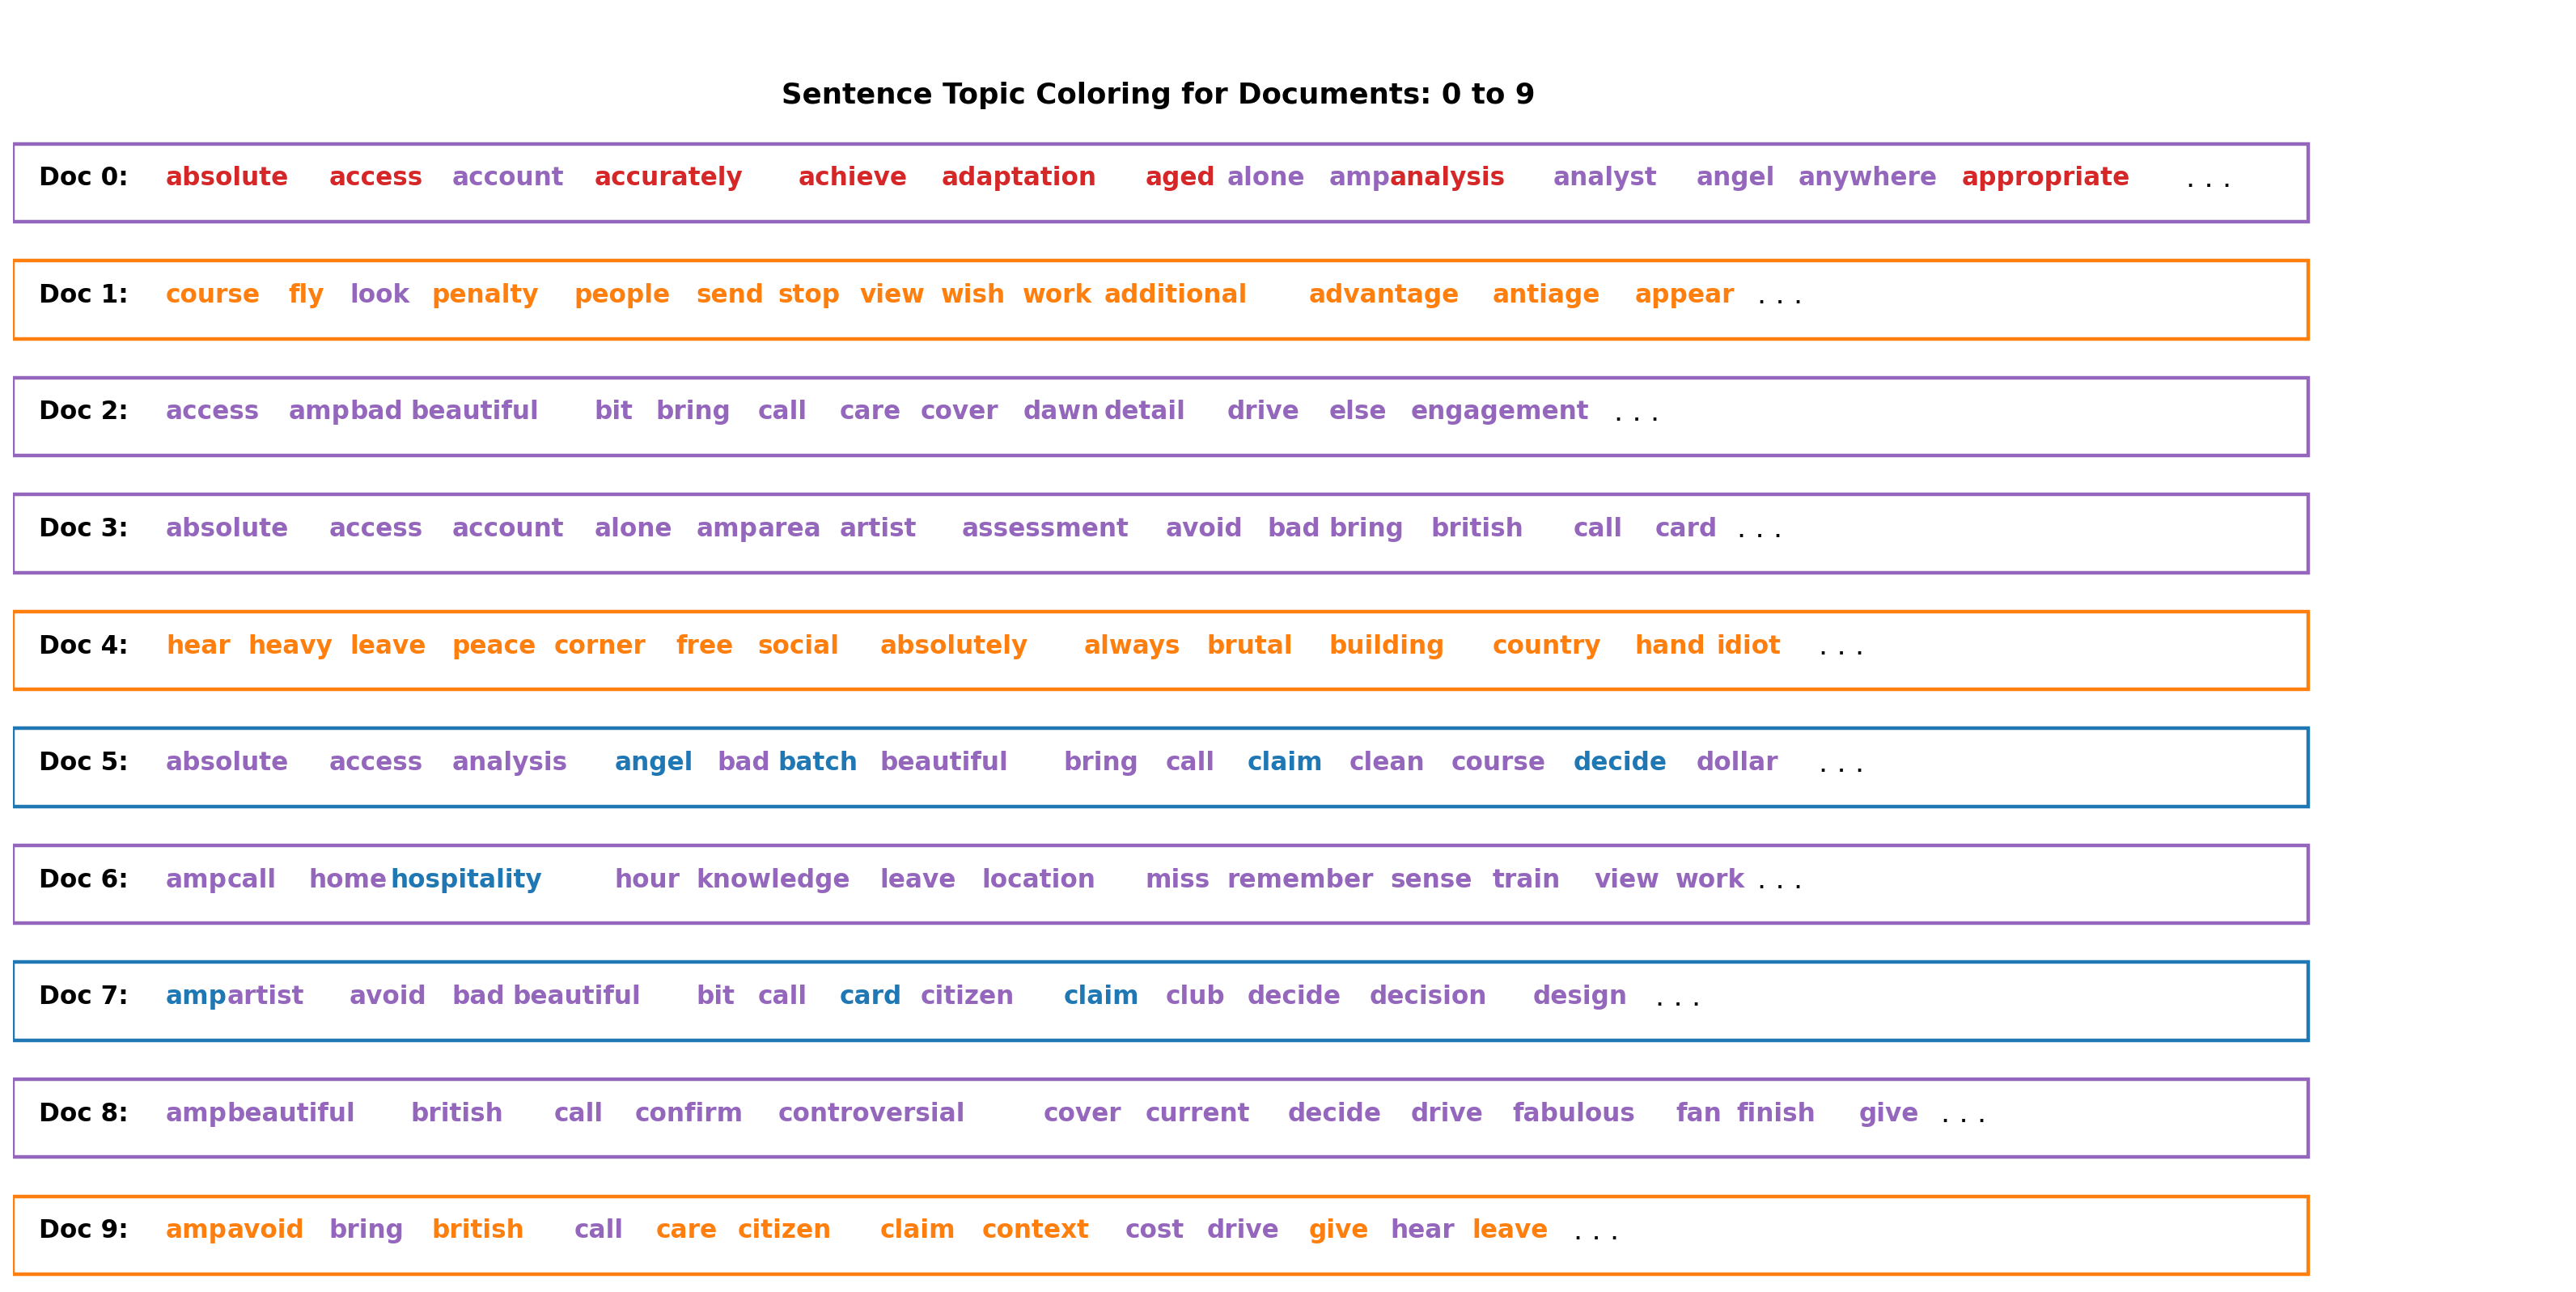

In [912]:
sentences_chart(model3,corpus3,0,11)

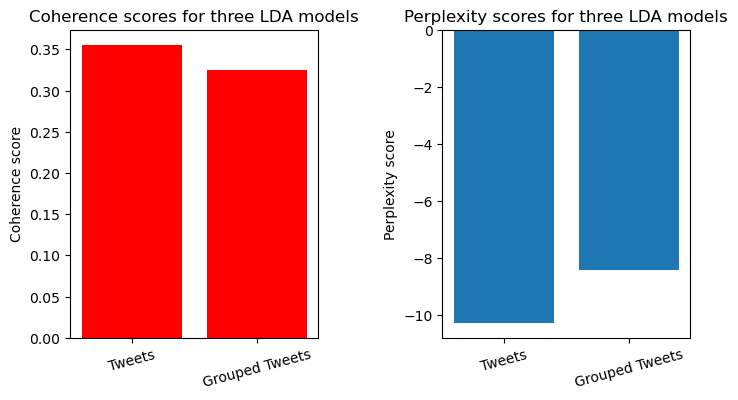

In [913]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# plot coherence scores in the first plot
coherence_scores = [coherence_score1, coherence_score3]
x_pos = np.arange(len(coherence_scores))

axs[0].bar(x_pos, coherence_scores, align='center',color='r')
axs[0].set_xticks(x_pos)
axs[0].set_xticklabels(['Tweets', 'Grouped Tweets'])
axs[0].set_ylabel('Coherence score')
axs[0].set_title('Coherence scores for three LDA models')
axs[0].tick_params(axis='x', rotation=15)
# plot perplexity scores in the second plot
perplexity_scores = [perplexity_score1, perplexity_score3]
x_pos = np.arange(len(perplexity_scores))

axs[1].bar(x_pos, perplexity_scores, align='center')
axs[1].set_xticks(x_pos)
axs[1].set_xticklabels(['Tweets',  'Grouped Tweets'])
axs[1].set_ylabel('Perplexity score')
axs[1].set_title('Perplexity scores for three LDA models')
axs[1].tick_params(axis='x', rotation=15)
plt.subplots_adjust(wspace=0.5, hspace=0)
plt.show()

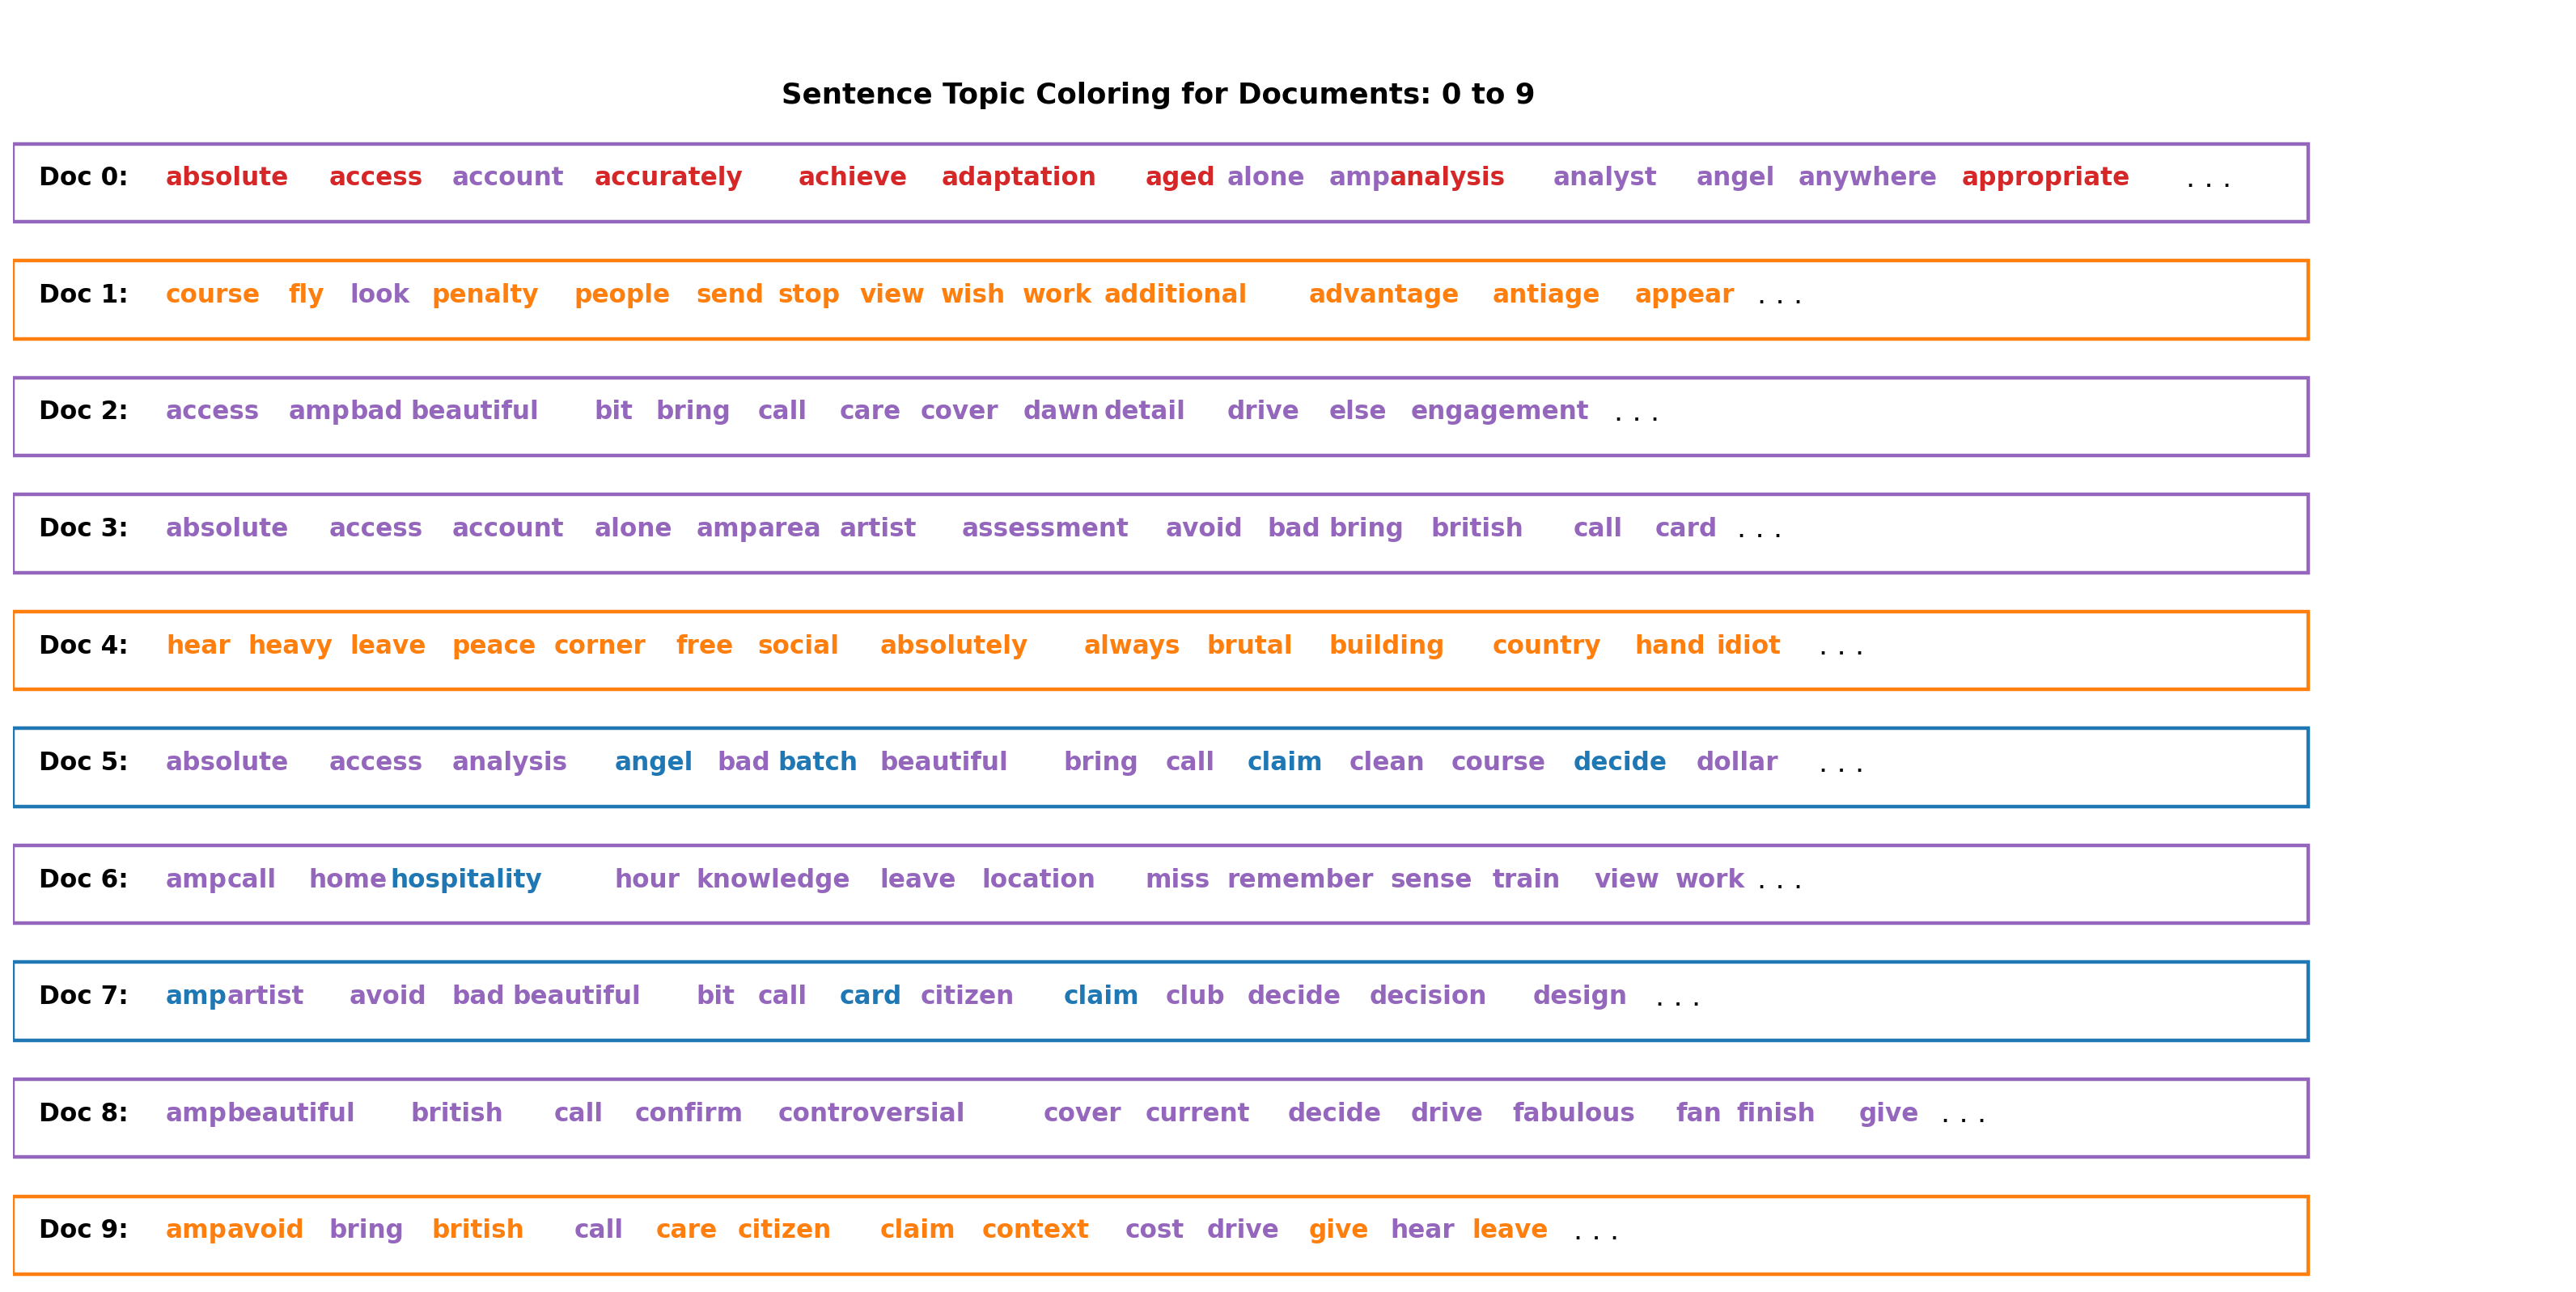